# Navigation

This notebook will train an agent to collect yellow bananas (and avoid blue bananas) in the Banana Collectors Unity environment.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip3 -q install ./python

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# please do not modify the line below
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain name', brain_name)

Brain name BananaBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Define the agent and deep RL algorithm.

In [7]:
from collections import OrderedDict, namedtuple, deque
import random
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [8]:
# Define hyperparamters.
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
SEED = 0xdeadbeef       # random seed
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the Q-hat network
NUM_EPISODES = 10       # how many episodes to run in the main DQN loop

In [9]:
# Get CPU or GPU device.
print('GPU is available:', torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU is available: False


In [10]:
# This replay buffer is only capable of randomly sampling experiences.
# TODO: implement prioritized sampling.
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    # TODO it appears that action_size is unused.
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Create a replay buffer.
        self.memory = ReplayBuffer(self.action_size, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=SEED)
        
        # The Q network is the local action-value network.
        hidden_sizes = [64, 128]
        self.Q_network = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(self.state_size, hidden_sizes[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                              ('relu2', nn.ReLU()),
                              ('logits', nn.Linear(hidden_sizes[1], self.action_size))]))
        
        # The Q_target network is the target action-value network. It is initialized with
        # the same weights as the local network.
        self.Q_target_network = copy.deepcopy(self.Q_network)
        
        # Print out the network architecture.
        print('Q networks have the following architecture:')
        print(self.Q_network)
        
        # If a GPU is available, convert the networks to CUDA form.
        if torch.cuda.is_available():
            self.Q_network = self.Q_network.cuda()
            self.Q_target_network = self.Q_target_network.cuda()
        
        self.optimizer = optim.Adam(self.Q_network.parameters(), lr=LR)
        
        self.t_step = 0
        
    def act(self, state, eps):
        """Returns an action for the given state."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.Q_network.eval()
        with torch.no_grad():
            action_values = self.Q_network(state)
        self.Q_network.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def step(self, state, action, reward, next_state, done):
        """Stores the (s, a, r, s', done) tuple in memory, then calls
        learn() if it is time to learn."""

        # Save experience in replay memory.
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn.
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model.
        Q_target_next = self.Q_target_network(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states.
        Q_targets = rewards + (gamma * Q_target_next * (1 - dones))

        # Get expected Q values from local model.
        Q_expected = self.Q_network(states).gather(1, actions)

        # Compute loss.
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss.
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network.
        self.soft_update(self.Q_network, self.Q_target_network, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self):
        """Saves model parameters to disk."""
        torch.save(self.Q_network.state_dict(), 'Q_network.pth')
        torch.save(self.Q_target_network.state_dict(), 'Q_target_network.pth')
        
    def load(self):
        """Loads model parameters from disk."""
        self.Q_network = nn.Sequential()
        self.Q_network.load_state_dict(torch.load('Q_network.pth'))
        self.Q_network.eval()
        
        self.Q_target_network = nn.Sequential()
        self.Q_target_network.load_state_dict(torch.load('Q_target_network.pth'))
        self.Q_target_network.eval()

In [12]:
# The DQN algorithm given in the class solution materials.
def DQN(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, debug=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        if debug: print('Start of episode', i_episode)
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]   
        if debug: print('State is', state)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            if debug: print('Agent chose action', action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            if debug: print('Next state is', next_state)
            reward = env_info.rewards[0]                   # get the reward
            if debug: print('Reward is', reward)
            done = env_info.local_done[0]                  # see if episode has finished
            if debug: print('Done is', done)
            agent.step(state, action, reward, next_state, done) # update the agent
            state = next_state                             # roll over the state to next time step
            score += reward
            if done:
                if debug: print('Agent completed task')
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

### 4. Run the deep RL algorithm.

Q networks have the following architecture:
Sequential(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (logits): Linear(in_features=128, out_features=4, bias=True)
)
Episode 100	Average Score: 0.28
Episode 200	Average Score: 4.05
Episode 300	Average Score: 7.23
Episode 400	Average Score: 9.58
Episode 500	Average Score: 12.02
Episode 600	Average Score: 13.22


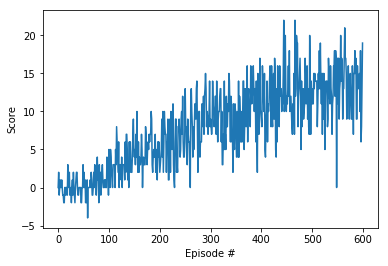

In [13]:
# Create the agent.
agent = Agent(state_size, action_size)

# Run vanilla DQN.
scores = DQN(n_episodes=600)

# Plot the scores.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Save the trained networks to disk.

In [14]:
# Save the learned parameters to a file on disk.
agent.save()